# Classifier using LSTM layers

## 1. Importing Libraries

In [1]:
import torch

import numpy as np
import pandas as pd

data_folder = '../data/quickdraw'

EPOCHS = 10
BATCH_SIZE = 64

MAX_SEQ_LENGTH = 95

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## 2. Data Preprocessing

### 2.1. Loading the data

In [2]:
import os


def get_categories_from_data(folder, n=None):
    """
    This function retrieves category names from file names in a specified folder. 
    The category name is assumed to be a substring of the file name, starting from the 17th character and ending 7 characters before the end of the file name.
    If the substring is empty, it is not added to the list of categories.
    If a limit 'n' is specified, only the first 'n' categories are returned.

    Parameters:
    folder (str): The path to the folder containing the files.
    n (int, optional): The maximum number of categories to return. If not specified, all categories are returned.

    Returns:
    list: A list of category names.
    """
    files = os.listdir(folder)
    categories = [file[16:-7] for file in files if len(file[16:-7]) > 0]
    return categories if n is None else categories[:n]

#classes = get_categories_from_data(data_folder)
classes = ["calculator", "camera", "cell phone"]
class_id = dict(zip(classes, range(len(classes))))

calculator_data = np.load(f'../data/sketchrnn/sketchrnn_calculator.npz', allow_pickle=True, encoding='latin1')
camera_data = np.load(f'../data/sketchrnn/sketchrnn_camera.npz', allow_pickle=True, encoding='latin1')
cellphone_data = np.load(f'../data/sketchrnn/sketchrnn_cell_phone.npz', allow_pickle=True, encoding='latin1')

class_id

{'calculator': 0, 'camera': 1, 'cell phone': 2}

In [3]:
def interpolate_strokes(strokes, target_length):
    """Interpolate a sequence of strokes to the target length."""
    current_length = len(strokes)
    if current_length == target_length:
        return strokes

    interpolated_strokes = np.zeros((target_length, 3), dtype=np.float32)
    interp_indices = np.floor(np.linspace(0, current_length-1, num=target_length)).astype(int)

    for i, idx in enumerate(interp_indices):
        interpolated_strokes[i] = strokes[idx]

    for i in range(target_length - 1):
        if interp_indices[i] != interp_indices[i + 1]:
            interpolated_strokes[i, 2] = strokes[interp_indices[i], 2]
        else:
            interpolated_strokes[i, 2] = 0

    # Ensure the last pen_state remains as the original last one
    interpolated_strokes[-1, 2] = strokes[-1, 2]

    return interpolated_strokes

def resize_and_normalize_drawings(data, size):
    """Resize and normalize drawing datasets."""
    resized_data = []
    for drawing in data['train']:
        resized_drawing = interpolate_strokes(drawing, size)
        resized_data.append(resized_drawing)
    return np.array(resized_data)

resized_calculator_drawings = resize_and_normalize_drawings(calculator_data, size=MAX_SEQ_LENGTH)
resized_camera_drawings = resize_and_normalize_drawings(camera_data, size=MAX_SEQ_LENGTH)
resized_cellphone_drawings = resize_and_normalize_drawings(cellphone_data, size=MAX_SEQ_LENGTH)

# TODO: Limitar dataset
resized_calculator_drawings = resized_calculator_drawings[:5120]
resized_cellphone_drawings = resized_cellphone_drawings[:5120]
resized_camera_drawings = resized_camera_drawings[:5120]

resized_camera_drawings.shape, resized_cellphone_drawings.shape, resized_calculator_drawings.shape

((5120, 95, 3), (5120, 95, 3), (5120, 95, 3))

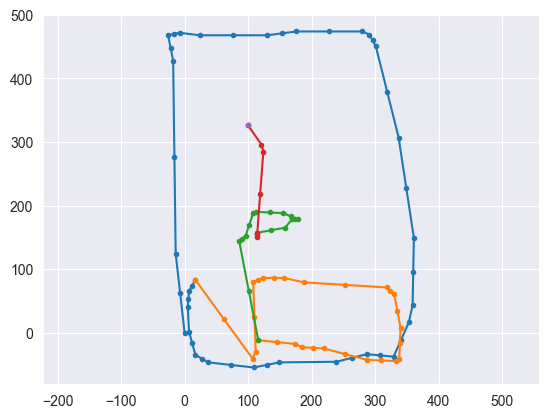

In [4]:
from matplotlib import pyplot as plt


def draw_strokes(data):
    """
    Draw stroke data from an array of (dx, dy, pen_state).

    Args:
    data (np.array): Stroke data array of shape (n, 3) where each row is (dx, dy, pen_state)
    """
    # Initialize a plot
    fig, ax = plt.subplots()

    # Starting point
    x, y = 0, 0
    points_x = [x]
    points_y = [y]

    # Iterate over the stroke data
    for dx, dy, pen_state in data:
        # Update position
        x += dx
        y += dy
        points_x.append(x)
        points_y.append(y)

        # If pen_state is 1, plot the current segment and start a new one
        if pen_state == 1:
            ax.plot(points_x, points_y, marker='.')
            points_x = [x]
            points_y = [y]

    # Plot the last segment
    ax.plot(points_x, points_y, marker='.')

    ax.axis('equal')
    plt.show()

draw_strokes(resized_calculator_drawings[0])

In [5]:
from sklearn.model_selection import train_test_split

def prepare_train_test_datasets(camera_drawings, cellphone_drawings, calculator_drawings, test_size=0.2):
    """
    Prepare training and testing datasets from the resized drawing data of cameras, cellphones, and calculators.

    Args:
    camera_drawings (np.array): Resized drawings of cameras.
    cellphone_drawings (np.array): Resized drawings of cellphones.
    calculator_drawings (np.array): Resized drawings of calculators.
    test_size (float): The proportion of the dataset to include in the test split.

    Returns:
    tuple: Train and test datasets containing features and labels.
    """
    camera_labels = np.ones(camera_drawings.shape[0])
    cellphone_labels = np.ones(cellphone_drawings.shape[0]) * 2
    calculator_labels = np.zeros(calculator_drawings.shape[0])

    combined_drawings = np.concatenate([camera_drawings, cellphone_drawings, calculator_drawings], axis=0)
    combined_labels = np.concatenate([camera_labels, cellphone_labels, calculator_labels], axis=0)

    X_train, X_test, y_train, y_test = train_test_split(
        combined_drawings, combined_labels, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_train_test_datasets(resized_camera_drawings, resized_cellphone_drawings, resized_calculator_drawings, test_size=0.2)

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12288, 95, 3), (12288,), (3072, 95, 3), (3072,))

In [7]:
from torch.utils.data import TensorDataset, DataLoader


def convert_to_tensor_datasets(X_train, X_test, y_train, y_test):
    """
    Convert numpy arrays into TensorFlow tensor datasets ready for model training.

    Args:
    X_train (np.array): Training features.
    X_test (np.array): Testing features.
    y_train (np.array): Training labels.
    y_test (np.array): Testing labels.
    batch_size (int): Size of batches for the dataset.

    Returns:
    tuple: TensorFlow datasets for training and testing.
    """
    train_dataset = TensorDataset(torch.tensor(X_train).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
    test_dataset = TensorDataset(torch.tensor(X_test).to(device), torch.tensor(y_test, dtype=torch.long).to(device))

    return train_dataset, test_dataset

train_dataset, test_dataset = convert_to_tensor_datasets(X_train, X_test, y_train, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
print(len(train_loader))
print(len(test_loader))

192
48


## 3. Model Building

### 3.1. Quantum Layer

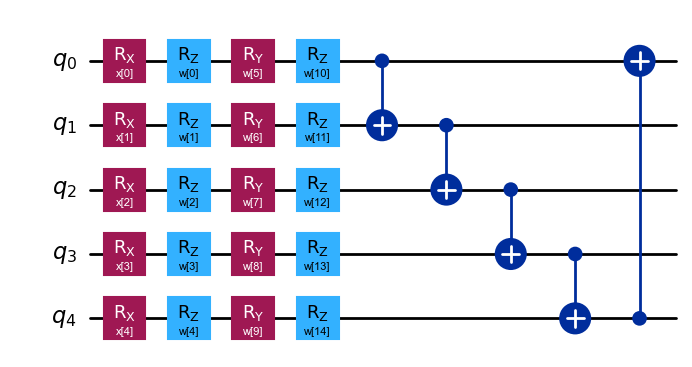

In [9]:
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector


def quantum_feature_map(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    features = ParameterVector("x", n)

    for i in range(n):
        circuit.rx(features[i], i)

    return circuit

def quantum_ansatz(n: int) -> QuantumCircuit:
    circuit = QuantumCircuit(n)
    weights = ParameterVector("w", n * 3)

    for i in range(n):
        circuit.rz(weights[i], i)

    for i in range(n):
        circuit.ry(weights[n+i], i)

    for i in range(n):
        circuit.rz(weights[2*n+i], i)

    for i in range(n-1):
        circuit.cx(i, i+1)
    circuit.cx(n-1, 0)

    return circuit

def create_qnn(n):
    feature_map = quantum_feature_map(n)
    ansatz = quantum_ansatz(n)

    qc = QuantumCircuit(n)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn, qc

qnn, qc = create_qnn(5)
qc.draw("mpl")

### 3.2. Hybrid Neural Network

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qiskit_machine_learning.connectors import TorchConnector

class HybridNN(nn.Module):
    def __init__(self, input_shape, num_categories, n_qubits=5, fname=None):
        super(HybridNN, self).__init__()
        self.num_categories = num_categories

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=16, kernel_size=4)
        self.bn1 = nn.BatchNorm1d(num_features=16)
        self.pool1 = nn.AvgPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5)
        self.bn2 = nn.BatchNorm1d(num_features=32)
        self.pool2 = nn.AvgPool1d(kernel_size=2)
        
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(num_features=64)
        self.pool3 = nn.AvgPool1d(kernel_size=2)
        
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(num_features=128)
        self.pool4 = nn.AvgPool1d(kernel_size=2)

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        
        self.pool5 = nn.AvgPool1d(kernel_size=2)

        # Dense layers
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 64)

        # Quantum layer
        self.fc3 = nn.Linear(64, n_qubits)
        self.qnn = TorchConnector(create_qnn(n_qubits)[0])

        # Dense layer for classification
        self.fc4 = nn.Linear(2**n_qubits, num_categories)

        # Load pre-trained weights
        if fname:
            self.load_state_dict(torch.load(fname))

    def forward(self, x):
        x = x.permute(0, 2, 1)

        # Convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        # Reshape for LSTM
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]

        # Pool layer
        x = self.pool5(x)

        # Flatten the output for dense layer
        x = torch.flatten(x, 1)

        # Dense layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Quantum layer
        x = F.relu(self.fc3(x))
        x = self.qnn(x)

        # Dense layer for classification
        x = F.relu(self.fc4(x))
        return x

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            x = x.unsqueeze(0)
            prediction = self.forward(x)
        return prediction.numpy()

## 4. Training the Model

In [11]:
checkpoint_filepath = 'models/2edition_quantum_lstm/best_model_weights_3classes.pth'

In [12]:
from tqdm import tqdm

input_shape = (95, 3)
model = HybridNN(input_shape, len(classes)).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Function to evaluate the model on validation data
def evaluate(model, test_loader):
    model.eval()
    total_correct = 0
    total_loss = 0
    total_samples = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += targets.size(0)

            total_loss += criterion(outputs, targets)
            total_correct += (predicted == targets).sum().item()
    model.train()
    return total_correct / total_samples, total_loss / len(test_loader)

# Training loop
best_accuracy = 0
accuracy_list = []
loss_list = []

val_accuracy_list = []
val_loss_list = []

for epoch in range(100):
    model.train()

    total_loss = []
    
    total_correct = 0
    total_samples = 0
    for inputs, labels in tqdm(train_loader):
        # Forward pass
        optimizer.zero_grad(set_to_none=True)
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        loss.backward()

        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()

        # Backward pass
        optimizer.step()
        total_loss.append(loss.item())

        total_samples += 1

    # Evaluate the model on the validation data after each epoch
    val_accuracy, val_loss = evaluate(model, test_loader)
    val_accuracy_list.append(val_accuracy)
    val_loss_list.append(val_loss)
    
    accuracy_list.append(total_correct / len(train_loader.dataset))
    loss_list.append(sum(total_loss) / len(train_loader))
    
    print(f'Epoch {epoch + 1}, Accuracy: {total_correct / len(train_loader.dataset)}, Loss: {sum(total_loss) / len(train_loader)}, Validation Accuracy: {val_accuracy}, Validation Loss: {val_loss}')

    # Checkpointing
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), checkpoint_filepath)

100%|██████████| 192/192 [11:51<00:00,  3.71s/it]


Epoch 1, Accuracy: 0.593994140625, Loss: 1.043556886414687, Validation Accuracy: 0.6256510416666666, Validation Loss: 0.9966698288917542


100%|██████████| 192/192 [11:15<00:00,  3.52s/it]


Epoch 2, Accuracy: 0.63232421875, Loss: 0.963638284864525, Validation Accuracy: 0.64453125, Validation Loss: 0.9243640899658203


100%|██████████| 192/192 [10:48<00:00,  3.38s/it]


Epoch 3, Accuracy: 0.64453125, Loss: 0.9043354575211803, Validation Accuracy: 0.6494140625, Validation Loss: 0.8771522045135498


100%|██████████| 192/192 [10:53<00:00,  3.41s/it]


Epoch 4, Accuracy: 0.6485188802083334, Loss: 0.8621744283785423, Validation Accuracy: 0.6481119791666666, Validation Loss: 0.8402854800224304


100%|██████████| 192/192 [10:49<00:00,  3.38s/it]


Epoch 5, Accuracy: 0.6485188802083334, Loss: 0.8343181271726886, Validation Accuracy: 0.6529947916666666, Validation Loss: 0.8159627914428711


100%|██████████| 192/192 [10:54<00:00,  3.41s/it]


Epoch 6, Accuracy: 0.6526692708333334, Loss: 0.8087414251640439, Validation Accuracy: 0.6555989583333334, Validation Loss: 0.7911093235015869


100%|██████████| 192/192 [10:36<00:00,  3.32s/it]


Epoch 7, Accuracy: 0.6542154947916666, Loss: 0.7874222372968992, Validation Accuracy: 0.6516927083333334, Validation Loss: 0.7974607944488525


100%|██████████| 192/192 [11:19<00:00,  3.54s/it]


Epoch 8, Accuracy: 0.6556803385416666, Loss: 0.7675802450006207, Validation Accuracy: 0.650390625, Validation Loss: 0.7616501450538635


100%|██████████| 192/192 [11:07<00:00,  3.48s/it]


Epoch 9, Accuracy: 0.6563313802083334, Loss: 0.7469974275057515, Validation Accuracy: 0.6533203125, Validation Loss: 0.7319063544273376


100%|██████████| 192/192 [11:05<00:00,  3.46s/it]


Epoch 10, Accuracy: 0.6571451822916666, Loss: 0.724352242735525, Validation Accuracy: 0.6549479166666666, Validation Loss: 0.7088899612426758


100%|██████████| 192/192 [10:50<00:00,  3.39s/it]


Epoch 11, Accuracy: 0.65869140625, Loss: 0.6979879994566242, Validation Accuracy: 0.6536458333333334, Validation Loss: 0.6882779598236084


100%|██████████| 192/192 [10:49<00:00,  3.39s/it]


Epoch 12, Accuracy: 0.658447265625, Loss: 0.6744391980270544, Validation Accuracy: 0.6458333333333334, Validation Loss: 0.6815118789672852


100%|██████████| 192/192 [11:05<00:00,  3.47s/it]


Epoch 13, Accuracy: 0.6563313802083334, Loss: 0.6539970822632313, Validation Accuracy: 0.6569010416666666, Validation Loss: 0.6439860463142395


100%|██████████| 192/192 [11:07<00:00,  3.48s/it]


Epoch 14, Accuracy: 0.659423828125, Loss: 0.6261319314750532, Validation Accuracy: 0.6539713541666666, Validation Loss: 0.634867250919342


100%|██████████| 192/192 [10:58<00:00,  3.43s/it]


Epoch 15, Accuracy: 0.6563313802083334, Loss: 0.6118114942995211, Validation Accuracy: 0.6539713541666666, Validation Loss: 0.6230862736701965


100%|██████████| 192/192 [11:02<00:00,  3.45s/it]


Epoch 16, Accuracy: 0.6580403645833334, Loss: 0.5915444083511829, Validation Accuracy: 0.6510416666666666, Validation Loss: 0.6254861354827881


100%|██████████| 192/192 [11:11<00:00,  3.50s/it]


Epoch 17, Accuracy: 0.6572265625, Loss: 0.5786750914218525, Validation Accuracy: 0.65625, Validation Loss: 0.5988638997077942


100%|██████████| 192/192 [10:55<00:00,  3.42s/it]


Epoch 18, Accuracy: 0.6577962239583334, Loss: 0.5718693832556406, Validation Accuracy: 0.6451822916666666, Validation Loss: 0.5842045545578003


100%|██████████| 192/192 [11:05<00:00,  3.46s/it]


Epoch 19, Accuracy: 0.658935546875, Loss: 0.5569851445034146, Validation Accuracy: 0.6529947916666666, Validation Loss: 0.5757204294204712


100%|██████████| 192/192 [10:52<00:00,  3.40s/it]


Epoch 20, Accuracy: 0.660400390625, Loss: 0.5459980826514462, Validation Accuracy: 0.654296875, Validation Loss: 0.5724579691886902


100%|██████████| 192/192 [10:56<00:00,  3.42s/it]


Epoch 21, Accuracy: 0.6595052083333334, Loss: 0.5353398971880475, Validation Accuracy: 0.65625, Validation Loss: 0.5599139928817749


100%|██████████| 192/192 [10:55<00:00,  3.41s/it]


Epoch 22, Accuracy: 0.6617024739583334, Loss: 0.5273271462259194, Validation Accuracy: 0.6565755208333334, Validation Loss: 0.5572071671485901


100%|██████████| 192/192 [11:12<00:00,  3.50s/it]


Epoch 23, Accuracy: 0.660400390625, Loss: 0.5209643902877966, Validation Accuracy: 0.6569010416666666, Validation Loss: 0.5543342232704163


100%|██████████| 192/192 [11:18<00:00,  3.53s/it]


Epoch 24, Accuracy: 0.662353515625, Loss: 0.513561119325459, Validation Accuracy: 0.6569010416666666, Validation Loss: 0.5425379872322083


100%|██████████| 192/192 [11:02<00:00,  3.45s/it]


Epoch 25, Accuracy: 0.6611328125, Loss: 0.5067949726556739, Validation Accuracy: 0.6497395833333334, Validation Loss: 0.5536525845527649


100%|██████████| 192/192 [11:10<00:00,  3.49s/it]


Epoch 26, Accuracy: 0.66162109375, Loss: 0.5032446309924126, Validation Accuracy: 0.6565755208333334, Validation Loss: 0.5413516163825989


100%|██████████| 192/192 [10:36<00:00,  3.32s/it]


Epoch 27, Accuracy: 0.6625162760416666, Loss: 0.49704760080203414, Validation Accuracy: 0.6565755208333334, Validation Loss: 0.53802090883255


100%|██████████| 192/192 [10:15<00:00,  3.20s/it]


Epoch 28, Accuracy: 0.6631673177083334, Loss: 0.49111639879023034, Validation Accuracy: 0.6442057291666666, Validation Loss: 0.5468198657035828


100%|██████████| 192/192 [10:11<00:00,  3.18s/it]


Epoch 29, Accuracy: 0.6630045572916666, Loss: 0.4867857623224457, Validation Accuracy: 0.65625, Validation Loss: 0.5363425612449646


100%|██████████| 192/192 [10:10<00:00,  3.18s/it]


Epoch 30, Accuracy: 0.6629231770833334, Loss: 0.47995333823685843, Validation Accuracy: 0.6585286458333334, Validation Loss: 0.5223571062088013


100%|██████████| 192/192 [10:10<00:00,  3.18s/it]


Epoch 31, Accuracy: 0.6640625, Loss: 0.47621854751681286, Validation Accuracy: 0.6591796875, Validation Loss: 0.534297525882721


100%|██████████| 192/192 [10:14<00:00,  3.20s/it]


Epoch 32, Accuracy: 0.662841796875, Loss: 0.4741099354190131, Validation Accuracy: 0.6578776041666666, Validation Loss: 0.5239669680595398


100%|██████████| 192/192 [10:16<00:00,  3.21s/it]


Epoch 33, Accuracy: 0.6631673177083334, Loss: 0.4721537623554468, Validation Accuracy: 0.6549479166666666, Validation Loss: 0.5185664892196655


100%|██████████| 192/192 [10:15<00:00,  3.20s/it]


Epoch 34, Accuracy: 0.66357421875, Loss: 0.4668273697607219, Validation Accuracy: 0.6585286458333334, Validation Loss: 0.5348338484764099


100%|██████████| 192/192 [10:11<00:00,  3.18s/it]


Epoch 35, Accuracy: 0.6632486979166666, Loss: 0.46096611488610506, Validation Accuracy: 0.6588541666666666, Validation Loss: 0.5268896222114563


100%|██████████| 192/192 [10:11<00:00,  3.18s/it]


Epoch 36, Accuracy: 0.6644694010416666, Loss: 0.45717687299475074, Validation Accuracy: 0.6552734375, Validation Loss: 0.5269753336906433


100%|██████████| 192/192 [10:10<00:00,  3.18s/it]


Epoch 37, Accuracy: 0.6638997395833334, Loss: 0.45088269483918947, Validation Accuracy: 0.6572265625, Validation Loss: 0.5252307653427124


100%|██████████| 192/192 [10:12<00:00,  3.19s/it]


Epoch 38, Accuracy: 0.6634114583333334, Loss: 0.4552655766407649, Validation Accuracy: 0.6591796875, Validation Loss: 0.5165198445320129


100%|██████████| 192/192 [10:14<00:00,  3.20s/it]


Epoch 39, Accuracy: 0.6651204427083334, Loss: 0.448470423463732, Validation Accuracy: 0.6591796875, Validation Loss: 0.5252403616905212


100%|██████████| 192/192 [10:10<00:00,  3.18s/it]


Epoch 40, Accuracy: 0.6656087239583334, Loss: 0.4433561717160046, Validation Accuracy: 0.6585286458333334, Validation Loss: 0.5185049176216125


100%|██████████| 192/192 [10:12<00:00,  3.19s/it]


Epoch 41, Accuracy: 0.6648763020833334, Loss: 0.44139390873412293, Validation Accuracy: 0.65625, Validation Loss: 0.5333569049835205


100%|██████████| 192/192 [10:10<00:00,  3.18s/it]


Epoch 42, Accuracy: 0.6642252604166666, Loss: 0.4388758564988772, Validation Accuracy: 0.658203125, Validation Loss: 0.5282039046287537


100%|██████████| 192/192 [10:11<00:00,  3.19s/it]


Epoch 43, Accuracy: 0.6640625, Loss: 0.4421372694584231, Validation Accuracy: 0.6591796875, Validation Loss: 0.5160996913909912


100%|██████████| 192/192 [10:11<00:00,  3.19s/it]


Epoch 44, Accuracy: 0.6649576822916666, Loss: 0.4337695126111309, Validation Accuracy: 0.6575520833333334, Validation Loss: 0.5128355026245117


100%|██████████| 192/192 [10:11<00:00,  3.18s/it]


Epoch 45, Accuracy: 0.6649576822916666, Loss: 0.4319553622044623, Validation Accuracy: 0.6516927083333334, Validation Loss: 0.513052761554718


100%|██████████| 192/192 [10:09<00:00,  3.17s/it]


Epoch 46, Accuracy: 0.6640625, Loss: 0.43519007274881005, Validation Accuracy: 0.6448567708333334, Validation Loss: 0.5202650427818298


100%|██████████| 192/192 [10:10<00:00,  3.18s/it]


Epoch 47, Accuracy: 0.6648763020833334, Loss: 0.4333393980438511, Validation Accuracy: 0.6585286458333334, Validation Loss: 0.5181646943092346


100%|██████████| 192/192 [10:09<00:00,  3.17s/it]


Epoch 48, Accuracy: 0.664306640625, Loss: 0.4297363481018692, Validation Accuracy: 0.6539713541666666, Validation Loss: 0.5230507254600525


100%|██████████| 192/192 [10:10<00:00,  3.18s/it]


Epoch 49, Accuracy: 0.6652018229166666, Loss: 0.4292743729117016, Validation Accuracy: 0.6588541666666666, Validation Loss: 0.5138826370239258


100%|██████████| 192/192 [10:09<00:00,  3.17s/it]


Epoch 50, Accuracy: 0.664794921875, Loss: 0.4255589776051541, Validation Accuracy: 0.6578776041666666, Validation Loss: 0.5324768424034119


100%|██████████| 192/192 [10:08<00:00,  3.17s/it]


Epoch 51, Accuracy: 0.6649576822916666, Loss: 0.42689642457601923, Validation Accuracy: 0.6552734375, Validation Loss: 0.5208361744880676


100%|██████████| 192/192 [10:10<00:00,  3.18s/it]


Epoch 52, Accuracy: 0.6651204427083334, Loss: 0.420665012827764, Validation Accuracy: 0.6572265625, Validation Loss: 0.5386251211166382


100%|██████████| 192/192 [10:10<00:00,  3.18s/it]


Epoch 53, Accuracy: 0.66552734375, Loss: 0.41810259067763883, Validation Accuracy: 0.6549479166666666, Validation Loss: 0.5318219661712646


100%|██████████| 192/192 [10:11<00:00,  3.19s/it]


Epoch 54, Accuracy: 0.665283203125, Loss: 0.415990078356117, Validation Accuracy: 0.6565755208333334, Validation Loss: 0.5179567337036133


100%|██████████| 192/192 [10:10<00:00,  3.18s/it]


Epoch 55, Accuracy: 0.6654459635416666, Loss: 0.4159319563768804, Validation Accuracy: 0.6559244791666666, Validation Loss: 0.5148314237594604


100%|██████████| 192/192 [10:10<00:00,  3.18s/it]


Epoch 56, Accuracy: 0.6654459635416666, Loss: 0.4176959032192826, Validation Accuracy: 0.6569010416666666, Validation Loss: 0.521724283695221


100%|██████████| 192/192 [10:11<00:00,  3.19s/it]


Epoch 57, Accuracy: 0.665283203125, Loss: 0.41095575077148777, Validation Accuracy: 0.654296875, Validation Loss: 0.5272263884544373


100%|██████████| 192/192 [10:11<00:00,  3.18s/it]


Epoch 58, Accuracy: 0.6651204427083334, Loss: 0.41708890558220446, Validation Accuracy: 0.6552734375, Validation Loss: 0.5329384207725525


100%|██████████| 192/192 [10:10<00:00,  3.18s/it]


Epoch 59, Accuracy: 0.66552734375, Loss: 0.4144248700855921, Validation Accuracy: 0.6572265625, Validation Loss: 0.5226083397865295


100%|██████████| 192/192 [10:09<00:00,  3.17s/it]


Epoch 60, Accuracy: 0.6659342447916666, Loss: 0.40945049258880317, Validation Accuracy: 0.6572265625, Validation Loss: 0.5257713198661804


100%|██████████| 192/192 [10:09<00:00,  3.18s/it]


Epoch 61, Accuracy: 0.666015625, Loss: 0.4057289309178789, Validation Accuracy: 0.6569010416666666, Validation Loss: 0.5303971171379089


100%|██████████| 192/192 [10:10<00:00,  3.18s/it]


Epoch 62, Accuracy: 0.6651204427083334, Loss: 0.4107420639290164, Validation Accuracy: 0.6539713541666666, Validation Loss: 0.5394036173820496


100%|██████████| 192/192 [10:11<00:00,  3.18s/it]


Epoch 63, Accuracy: 0.6653645833333334, Loss: 0.41121986663589877, Validation Accuracy: 0.6555989583333334, Validation Loss: 0.537638247013092


100%|██████████| 192/192 [10:12<00:00,  3.19s/it]


Epoch 64, Accuracy: 0.6654459635416666, Loss: 0.41316673276014626, Validation Accuracy: 0.6572265625, Validation Loss: 0.516767680644989


100%|██████████| 192/192 [10:11<00:00,  3.19s/it]


Epoch 65, Accuracy: 0.6658528645833334, Loss: 0.40574883910206455, Validation Accuracy: 0.6539713541666666, Validation Loss: 0.536217987537384


100%|██████████| 192/192 [10:11<00:00,  3.19s/it]


Epoch 66, Accuracy: 0.66552734375, Loss: 0.4041101823871334, Validation Accuracy: 0.6429036458333334, Validation Loss: 0.5246382355690002


100%|██████████| 192/192 [10:03<00:00,  3.14s/it]


Epoch 67, Accuracy: 0.66552734375, Loss: 0.40581231269364554, Validation Accuracy: 0.66015625, Validation Loss: 0.5202506184577942


100%|██████████| 192/192 [09:54<00:00,  3.10s/it]


Epoch 68, Accuracy: 0.6650390625, Loss: 0.40846094333877164, Validation Accuracy: 0.6569010416666666, Validation Loss: 0.5125150084495544


100%|██████████| 192/192 [10:09<00:00,  3.17s/it]


Epoch 69, Accuracy: 0.6659342447916666, Loss: 0.4006706193710367, Validation Accuracy: 0.6533203125, Validation Loss: 0.5452572107315063


100%|██████████| 192/192 [10:00<00:00,  3.13s/it]


Epoch 70, Accuracy: 0.665283203125, Loss: 0.4023780529387295, Validation Accuracy: 0.6578776041666666, Validation Loss: 0.5319947600364685


100%|██████████| 192/192 [09:48<00:00,  3.07s/it]


Epoch 71, Accuracy: 0.66552734375, Loss: 0.4029268978629261, Validation Accuracy: 0.6585286458333334, Validation Loss: 0.5566375851631165


100%|██████████| 192/192 [09:40<00:00,  3.02s/it]


Epoch 72, Accuracy: 0.6648763020833334, Loss: 0.4064907900368174, Validation Accuracy: 0.6516927083333334, Validation Loss: 0.5228070616722107


100%|██████████| 192/192 [09:42<00:00,  3.03s/it]


Epoch 73, Accuracy: 0.665771484375, Loss: 0.40120045375078917, Validation Accuracy: 0.6588541666666666, Validation Loss: 0.5513362288475037


100%|██████████| 192/192 [09:35<00:00,  3.00s/it]


Epoch 74, Accuracy: 0.666015625, Loss: 0.4002032869805892, Validation Accuracy: 0.6500651041666666, Validation Loss: 0.5451961159706116


100%|██████████| 192/192 [09:33<00:00,  2.99s/it]


Epoch 75, Accuracy: 0.6650390625, Loss: 0.4041222888045013, Validation Accuracy: 0.6559244791666666, Validation Loss: 0.531182587146759


100%|██████████| 192/192 [09:34<00:00,  2.99s/it]


Epoch 76, Accuracy: 0.6653645833333334, Loss: 0.4030553342308849, Validation Accuracy: 0.6549479166666666, Validation Loss: 0.5415704846382141


100%|██████████| 192/192 [09:34<00:00,  2.99s/it]


Epoch 77, Accuracy: 0.666015625, Loss: 0.3968240156924973, Validation Accuracy: 0.6565755208333334, Validation Loss: 0.5331943035125732


100%|██████████| 192/192 [09:33<00:00,  2.98s/it]


Epoch 78, Accuracy: 0.665771484375, Loss: 0.39751996418150765, Validation Accuracy: 0.6569010416666666, Validation Loss: 0.5663627982139587


100%|██████████| 192/192 [09:31<00:00,  2.98s/it]


Epoch 79, Accuracy: 0.6659342447916666, Loss: 0.3975150880093376, Validation Accuracy: 0.6572265625, Validation Loss: 0.5497904419898987


100%|██████████| 192/192 [09:32<00:00,  2.98s/it]


Epoch 80, Accuracy: 0.6656087239583334, Loss: 0.3965162149009605, Validation Accuracy: 0.6555989583333334, Validation Loss: 0.5354798436164856


100%|██████████| 192/192 [09:36<00:00,  3.00s/it]


Epoch 81, Accuracy: 0.6656087239583334, Loss: 0.39801318749474984, Validation Accuracy: 0.6572265625, Validation Loss: 0.554639995098114


100%|██████████| 192/192 [09:36<00:00,  3.01s/it]


Epoch 82, Accuracy: 0.6651204427083334, Loss: 0.39960662042722106, Validation Accuracy: 0.6533203125, Validation Loss: 0.5311976075172424


100%|██████████| 192/192 [09:37<00:00,  3.01s/it]


Epoch 83, Accuracy: 0.6658528645833334, Loss: 0.3991024208565553, Validation Accuracy: 0.6572265625, Validation Loss: 0.5490174293518066


100%|██████████| 192/192 [09:36<00:00,  3.00s/it]


Epoch 84, Accuracy: 0.6654459635416666, Loss: 0.397290571903189, Validation Accuracy: 0.6552734375, Validation Loss: 0.5526344180107117


100%|██████████| 192/192 [09:36<00:00,  3.00s/it]


Epoch 85, Accuracy: 0.6652018229166666, Loss: 0.4003922981210053, Validation Accuracy: 0.658203125, Validation Loss: 0.540103018283844


100%|██████████| 192/192 [09:36<00:00,  3.00s/it]


Epoch 86, Accuracy: 0.66552734375, Loss: 0.3939575191276769, Validation Accuracy: 0.6578776041666666, Validation Loss: 0.5622686743736267


100%|██████████| 192/192 [09:36<00:00,  3.00s/it]


Epoch 87, Accuracy: 0.666015625, Loss: 0.39300224153945845, Validation Accuracy: 0.6510416666666666, Validation Loss: 0.5448080897331238


100%|██████████| 192/192 [09:36<00:00,  3.00s/it]


Epoch 88, Accuracy: 0.66552734375, Loss: 0.39260166930034757, Validation Accuracy: 0.6536458333333334, Validation Loss: 0.5406257510185242


100%|██████████| 192/192 [09:36<00:00,  3.00s/it]


Epoch 89, Accuracy: 0.66552734375, Loss: 0.40126007647874457, Validation Accuracy: 0.6575520833333334, Validation Loss: 0.542354166507721


100%|██████████| 192/192 [09:39<00:00,  3.02s/it]


Epoch 90, Accuracy: 0.665771484375, Loss: 0.39351656621632475, Validation Accuracy: 0.65625, Validation Loss: 0.5939851403236389


100%|██████████| 192/192 [09:40<00:00,  3.02s/it]


Epoch 91, Accuracy: 0.6661783854166666, Loss: 0.39172168689159054, Validation Accuracy: 0.6569010416666666, Validation Loss: 0.5499810576438904


100%|██████████| 192/192 [09:37<00:00,  3.01s/it]


Epoch 92, Accuracy: 0.666015625, Loss: 0.3912508913005392, Validation Accuracy: 0.6575520833333334, Validation Loss: 0.5536700487136841


100%|██████████| 192/192 [09:42<00:00,  3.03s/it]


Epoch 93, Accuracy: 0.6660970052083334, Loss: 0.3928404731365542, Validation Accuracy: 0.658203125, Validation Loss: 0.5512338280677795


100%|██████████| 192/192 [09:42<00:00,  3.03s/it]


Epoch 94, Accuracy: 0.665283203125, Loss: 0.3932505059832086, Validation Accuracy: 0.6549479166666666, Validation Loss: 0.5579010248184204


100%|██████████| 192/192 [09:41<00:00,  3.03s/it]


Epoch 95, Accuracy: 0.66552734375, Loss: 0.39279512541058165, Validation Accuracy: 0.6572265625, Validation Loss: 0.5546401143074036


100%|██████████| 192/192 [09:41<00:00,  3.03s/it]


Epoch 96, Accuracy: 0.6659342447916666, Loss: 0.3930786969140172, Validation Accuracy: 0.6572265625, Validation Loss: 0.5439900159835815


100%|██████████| 192/192 [09:44<00:00,  3.04s/it]


Epoch 97, Accuracy: 0.666015625, Loss: 0.3896165522746742, Validation Accuracy: 0.6565755208333334, Validation Loss: 0.5870326161384583


100%|██████████| 192/192 [09:43<00:00,  3.04s/it]


Epoch 98, Accuracy: 0.6659342447916666, Loss: 0.3901646028583248, Validation Accuracy: 0.6575520833333334, Validation Loss: 0.55255526304245


100%|██████████| 192/192 [09:43<00:00,  3.04s/it]


Epoch 99, Accuracy: 0.6646321614583334, Loss: 0.3967433347521971, Validation Accuracy: 0.6578776041666666, Validation Loss: 0.5408560633659363


100%|██████████| 192/192 [09:44<00:00,  3.04s/it]


Epoch 100, Accuracy: 0.666015625, Loss: 0.39265842316672206, Validation Accuracy: 0.6536458333333334, Validation Loss: 0.5544212460517883


## 5. Model Evaluation

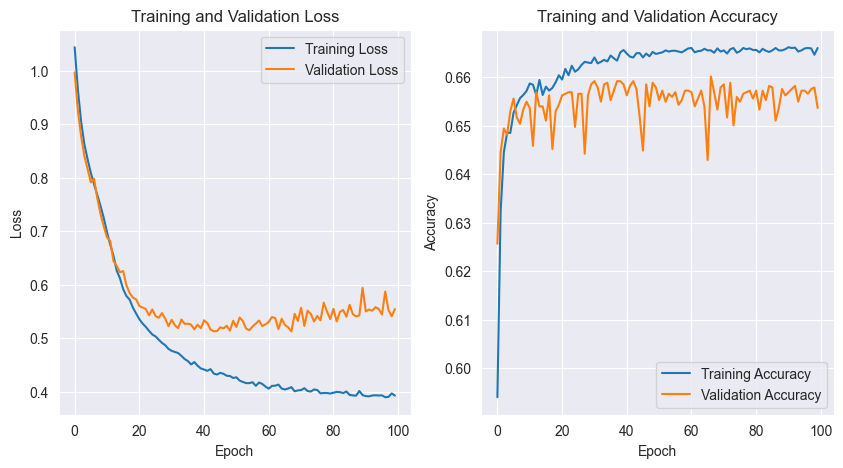

In [13]:
def plot_graphs(loss_list, val_loss_list, accuracy_list, val_accuracy_list):
    plt.figure(figsize=(10, 5))

    # Plotting loss
    plt.subplot(1, 2, 1)
    plt.plot(loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_list, label='Training Accuracy')
    plt.plot(val_accuracy_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plot_graphs(loss_list, val_loss_list, accuracy_list, val_accuracy_list)

In [14]:
model = HybridNN(input_shape, num_categories=len(classes), fname=checkpoint_filepath)

In [15]:
INDEX = 0

out = model.predict(X_test[:2500][INDEX])
print("Predicted class:", classes[np.argmax(out)])
print("True class:", classes[y_test[INDEX].astype(int)])

Predicted class: calculator
True class: cell phone
